<a href="https://colab.research.google.com/github/xpewa/Technopark_ML/blob/main/ML_DZ_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Методы обучения без учителя: Домашняя работа
Правила:
*   Отчеты принимаются до 23:59 21 ноября. Вы должны залить ваш ноутбук в colab и дать на него ссылку в форме сдачи ДЗ на портале
*   Работоспособность будет проверяться в коллабе. Это значит что:
1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab 
2. Убедитесь, что данные автоматически подгружается с помощью команды !wget (см семинары для примера).  Все нужные данные есть здесь 
3. Все необходимые модули тоже устанавливаются на лету через !pip

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках
В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными данными являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [ ]:
!mkdir ./data
!wget https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_database.csv -O ./data/sign_database.csv
!wget https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_classes.csv -O ./data/sign_classes.csv

mkdir: cannot create directory ‘./data’: File exists
--2021-11-21 19:38:04--  https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_database.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32681203 (31M) [text/plain]
Saving to: ‘./data/sign_database.csv’

./data/sign_databas 100%[===================>]  31.17M   169MB/s    in 0.2s    

2021-11-21 19:38:05 (169 MB/s) - ‘./data/sign_database.csv’ saved [32681203/32681203]

--2021-11-21 19:38:05--  https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/sign_classes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.1

In [ ]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [ ]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,yaw_l,yaw_r,thumb_l,thumb_r,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,0.019041,0.046011,-0.106124,-0.006852,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,0.019041,0.047708,-0.050000,-0.009621,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,0.019041,-0.006363,-0.029461,0.017169,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,0.019041,-0.085527,-0.003653,0.138081,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,0.019041,-0.026098,0.100024,0.153798,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [ ]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

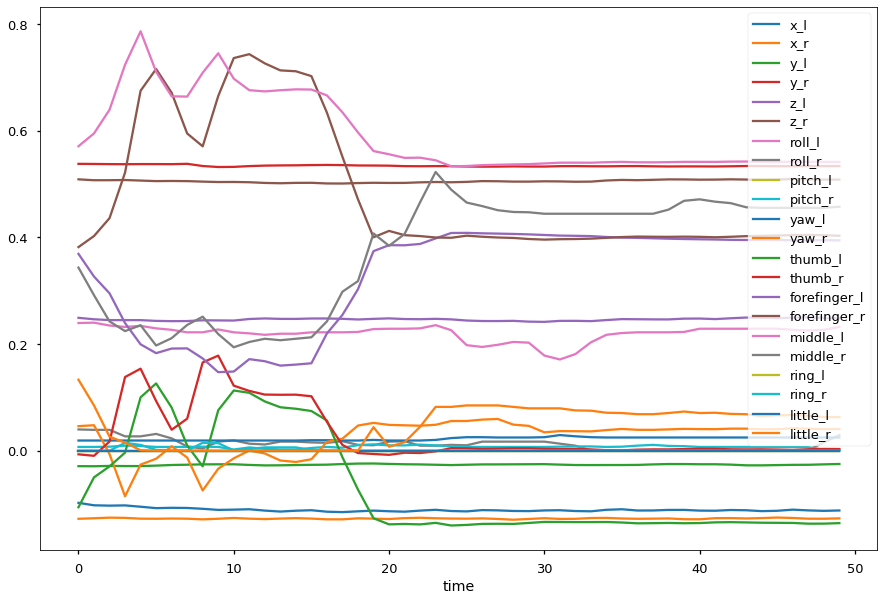

In [ ]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

# Расчет новых признаков

Признаки мы будем считать с помощью библиотеки tsfresh. Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# # Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh

# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [ ]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: cannot create directory ‘./data’: File exists
--2021-11-21 19:38:06--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-11-21 19:38:07--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaca835c21148c55ca76b701e47.dl.dropboxusercontent.com/cd/0/inline/Baba0jBRbuoY09QWgYKpoI4aA2JTB9n0MZtkPuvOpYp-U0Q8Y2L8pp6meP4BAUm10BTUXJtgEc1bHoynr0B_uOxnFaTBlwJ_pZG2iiIKzCHgHcpAFnj_Go-hwfxbs07f_wcQtUWSLisgrtaMHmSVdoHL/file# [following]
--2021-11-21 19:38:07--  https://ucaca835c21148c55ca76b701e47.dl.dropboxusercontent.

In [ ]:
sign_features_filtered.shape

(2565, 11517)

In [ ]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","ring_r__fft_coefficient__attr_""abs""__coeff_1","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","ring_r__fft_coefficient__attr_""imag""__coeff_1","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","ring_r__linear_trend__attr_""slope""","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",ring_r__cid_ce__normalize_False,"ring_r__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ring_r__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","ring_r__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""",...,y_r__has_duplicate_max,x_r__large_standard_deviation__r_0.45,x_r__large_standard_deviation__r_0.15000000000000002,yaw_l__symmetry_looking__r_0.25,yaw_l__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.2,forefinger_r__has_duplicate_min,forefinger_r__symmetry_looking__r_0.05,roll_l__symmetry_looking__r_0.15000000000000002,roll_l__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.35000000000000003,z_r__large_standard_deviation__r_0.45,forefinger_r__large_standard_deviation__r_0.2,forefinger_r__large_standard_deviation__r_0.45,yaw_r__large_standard_deviation__r_0.4,forefinger_l__has_duplicate_min,thumb_r__large_standard_deviation__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.30000000000000004,z_r__symmetry_looking__r_0.35000000000000003,forefinger_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.25,thumb_l__symmetry_looking__r_0.4,thumb_l__symmetry_looking__r_0.1,middle_l__symmetry_looking__r_0.35000000000000003,pitch_l__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.2,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_stand

# Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [ ]:
enc = LabelEncoder()
enc.fit(sign_classes.loc[:, 'class'])
sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

In [ ]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes.target.values

In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
base_cv_scores.mean()

0.9196881091617932

# Метод главных компонент (5 баллов)



*   (1) Добавьте в пайплайн base_model шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: svd_solder = "randomized" и random_state=123. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
*   (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая.
*   (1) Укажите долю объяснённой дисперсии при найденной настройке PCA (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте explained_variance_ratio

In [ ]:
base_cv_scores_means = []
#n_components_range = range(1, 250, 50)
#n_components_range = range(65, 85, 5)
n_components_range = range(76, 79, 1)

for i in n_components_range:
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

  base_model = Pipeline([
      ('scaler', StandardScaler()),
      ('pca', PCA(svd_solver="randomized", random_state=123, n_components=i)),
      ('clf', KNeighborsClassifier(n_neighbors=9))
  ])

  base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
  base_cv_scores_means.append(base_cv_scores.mean())

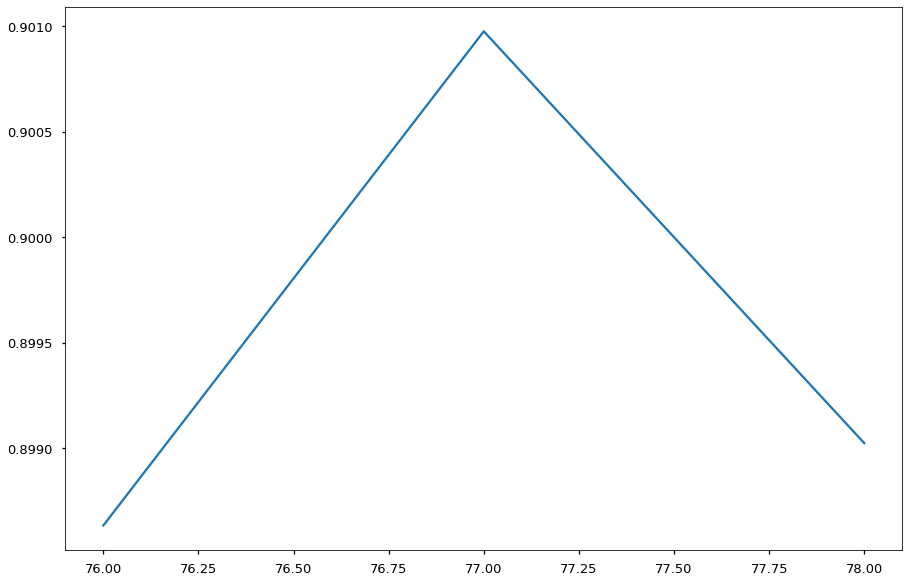

In [ ]:
plt.plot(n_components_range, base_cv_scores_means)

In [ ]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver="randomized", random_state=123, n_components=77)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()


0.9009746588693958

In [ ]:
pca = PCA(n_components=77)
pca.fit(X)
np.cumsum(pca.explained_variance_ratio_)[-1]

0.9999999999999992

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:

* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано
* его рубрика

In [ ]:
!wget https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/news.csv -O ./data/news.csv
df = pd.read_csv('./data/news.csv', encoding='utf8')
df.head()

--2021-11-21 19:40:12--  https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13352242 (13M) [text/plain]
Saving to: ‘./data/news.csv’

./data/news.csv     100%[===================>]  12.73M  --.-KB/s    in 0.09s   

2021-11-21 19:40:12 (144 MB/s) - ‘./data/news.csv’ saved [13352242/13352242]



,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [ ]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

# Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [ ]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [ ]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [ ]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2021-11-21 19:40:18--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.243, 5.45.205.241, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-11-21 19:40:19--  http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)... 5.45.205.221, 2a02:6b8::3:221
Connecting to cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)|5.45.205.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.2’

mystem-3.0-linux3.1 100%[===================>]  15.70M 

In [ ]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 3.42 s, sys: 194 ms, total: 3.62 s
Wall time: 22.3 s


In [ ]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [ ]:
df.text[0] # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

# Вычисление сходства (1 балл)

С помощью TfidfVectorizer и pairwise_distances расчитайте косинусное расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью CountVectorizer или TfidfVectorizer можно почитать тут

Запишите результат в переменную S

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [ ]:
vect = TfidfVectorizer()
texts = df.text.values

In [ ]:
matrix = vect.fit_transform(texts)

In [ ]:
S = pairwise_distances(matrix, metric='cosine')

[[], []]

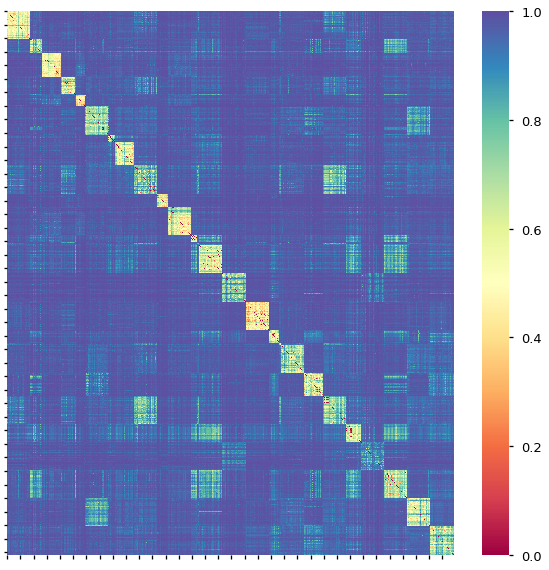

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести.

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

# DBSCAN (4 балла)

* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите min_pts = 2 из семинара! Используйте косинусную меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью Adjusted Rand Index

Определим min_pts методом проб и ошибок

In [ ]:
min_pts = 10

Определим epsilon

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

nn = NearestNeighbors(n_neighbors = min_pts, metric='cosine')
nn.fit(matrix)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [ ]:
dist, _ = nn.kneighbors(matrix)
dist_last = dist[:, -1]
dist_last = np.sort(dist_last)

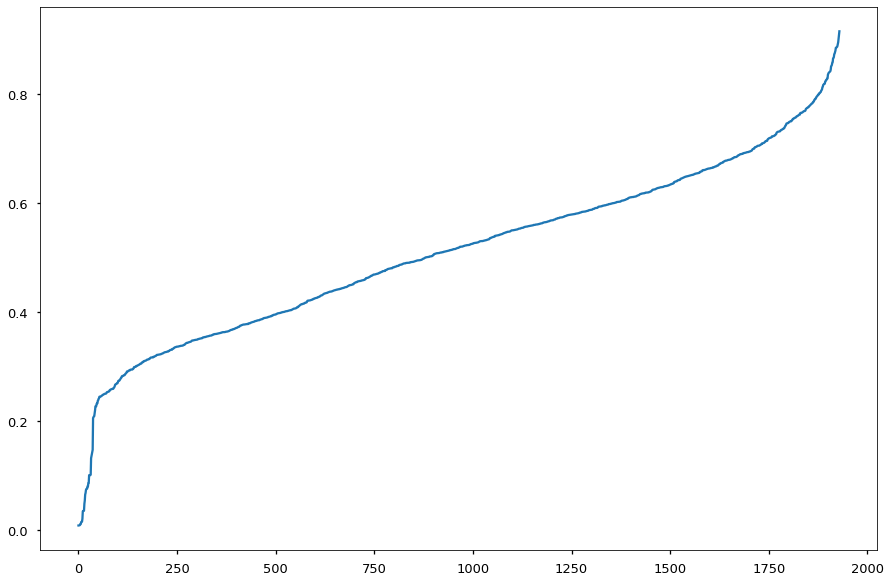

In [ ]:
plt.plot(dist_last)

In [ ]:
eps = 0.7

In [ ]:
dbscan = DBSCAN(eps = eps, min_samples=min_pts, metric='cosine').fit(matrix)

labels = dbscan.labels_
len(set(labels))

12

Проанализируем кластеры

In [ ]:
df.loc[:, 'labels'] = labels
true_label = df.loc[:,'class']

In [ ]:
df[df.labels == 0].text[:5]

# Внутренняя политика РФ: оппозиция

0    петербург проходить митинг против передача иса...
1    москва январь ситуация передача исаакиевский с...
2    аргумент факт москва январь оппозиция проводит...
3    новость топ москва январь акция против передач...
4    газета москва январь московский патриархия про...
Name: text, dtype: object

In [ ]:
df[df.labels == 1].text[:5]

# кластер Трампа :)

100    инаугурация го президент сша дональд трамп пол...
101    москва январь глас соцсеть инаугурация трамп в...
102    москва январь трамп подписывать первый докумен...
103    дэлайт новость москва январь инаугурация трамп...
104    дэлайт новость москва январь инаугурация трамп...
Name: text, dtype: object

In [ ]:
df[df.labels == 2].text[:5]

# Международные отношения

151    умирать виталий чуркин постоянный представител...
152    москва февраль москвич нести цветок здание мид...
153    москва февраль путин посмертно награждать чурк...
154    москва февраль москвич нести цветок здание мид...
155    москва февраль неожиданный смерть мид рф сложн...
Name: text, dtype: object

In [ ]:
df[df.labels == 3].text[:5]

# Важные мировые события

299    восемь сердце рокфеллер скончаться миллиардер ...
300    геополитика москва март умирать дэвид рокфелле...
301    москва март умирать дэвид рокфеллер факт жизнь...
302    сми москва март м год жизнь умирать старый мил...
303    москва март умирать дэвид рокфеллер миллиардер...
Name: text, dtype: object

In [ ]:
df[df.labels == 4].text[:5]

# Внутренняя политика: культура

440    юлия самойлов евровидение запрет реакция певиц...
441    москва март юлия самойлов евровидение запрет р...
442    москва март юлия самойлов евровидение запрет р...
443    москва март участница евровидение рф юлия само...
444    москва март юлия самойлов евровидение новость ...
Name: text, dtype: object

In [ ]:
df[df.labels == 5].text[:5]

# Криминальная хроника

467    упор рикошет автор польгуев екатерина выстрел ...
468    новость москва март украинский сми убийца воро...
469    империя москва март украинский сми убийца воро...
470    взгляд ру москва март украинский сми убийца во...
471    русый инфо москва март киев застреливать бывши...
Name: text, dtype: object

In [ ]:
df[df.labels == 6].text[:5]

# Технологии

649    рогозин поздравлять илона маска удачный запуск...
650    яндекс новость москва март проводить повторный...
651    яндекс новость москва март рогозин поздравлять...
652    москва март производить ый история повторный з...
653    серебряный дождь москва март дмитрий рогозин п...
Name: text, dtype: object

In [ ]:
df[df.labels == 7].text[:5]

# Тоже похожу на культуру

698    поэт автор яхонтов андрей умирать евгений евту...
699    москва апрель евгений евтушенко рок звезда сов...
700    известие москва апрель современник запоминать ...
701    москва апрель умирать евгений евтушенко вдова ...
702    москва апрель максим галкин выкладывать поклон...
Name: text, dtype: object

In [ ]:
df[df.labels == 8].text[:5]

# Спорт

931    тасс москва май команда россия сша разыгрывать...
932    риа новость москва май выходить плей офф сборн...
933    известие москва май кельн медаль автор алексей...
934    тасс москва май очередной испытание команда зн...
935    тасс москва май плохой лед золушка латвия чм х...
Name: text, dtype: object

In [ ]:
df[df.labels == 9].text[:5]

# Внутренняя политика РФ

1033    турист скидываться рубль крым автор фаляхов ру...
1034    яндекс новость москва май дума вносить законоп...
1035    москва май правительство вносить госдума закон...
1036    москва май госдума вносить законопроект курорт...
1037    москва май госдума вносить законопроект курорт...
Name: text, dtype: object

In [ ]:
df[df.labels == 10].text[:5]

# Проишествия РФ

1186    жертва ураган москва список компенсация ураган...
1187    институт религия политика москва май результат...
1188    москва май увеличиваться количество пострадавш...
1189    поливать грамота москва май жертва ураган моск...
1190    москва май ск рф сообщать новый сведение погиб...
Name: text, dtype: object

In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,,,
Важные мировые события,0,0,278,84,41,0,0,0,0,0,0,0
Внутренняя политика РФ,3,100,161,0,0,0,0,0,0,0,100,0
Внутренняя политика РФ: оппозиция,22,0,255,0,0,0,0,0,0,0,0,0
Внутренняя политика: культура,1,0,0,0,0,0,0,0,99,0,0,0
Международные отношения,1,0,125,0,0,27,0,0,0,0,0,0
Международные отношения: Криминальная хроника,0,0,0,0,0,0,82,0,0,0,0,0
Проишествия РФ,1,0,0,0,0,0,0,0,0,0,0,99
Спорт,67,0,0,0,0,0,0,0,0,33,0,0
Спорт,4,0,0,0,0,0,0,0,0,98,0,0


In [ ]:
adjusted_rand_score(true_label, labels)

0.2290289811320809